# Apache Spark
## Intro
Oh man... _**SPARK**_... Where to start. First of all, pretty much everything in this post will be based on [this seminar](https://www.youtube.com/watch?v=7ooZ4S7Ay6Y) by Sameer Farooqi from Databricks.

[![](https://img.youtube.com/vi/7ooZ4S7Ay6Y/0.jpg)](https://www.youtube.com/watch?v=7ooZ4S7Ay6Y)

It's a full-day seminar, and yes, I watched all _**6 hours**_. Me after watching the video:

<img src="https://68.media.tumblr.com/dc68e3863b4d5eb31ae955d2d29a4c07/tumblr_njw39iTJBY1r1d4seo1_500.gif" width="400">

Me realizing where my day has gone:
<img src="https://img.buzzfeed.com/buzzfeed-static/static/2013-09/enhanced/webdr05/26/1/anigif_enhanced-buzz-6772-1380172174-4.gif" width="400">

Hey, this is the life that was given to me. I must make lemonade out of it!

But yeah anyways, what the hell is Spark lol. At the end of the day, it's another tool to leverage distributed processing. Most of what we went over with Hadoop last post can be directly applied to Spark. There exists masters and workers, it seems to be relatively easily scaled up and down, and we have a slew of data manipulation and analysis tools available to us. I don't even know how to summarize this in a single post, but I'll try to hit on some of the points that stood out to me in my analysis:
- Distributed, in-memory processing
- Python API
- Design architecture & Directed Acyclic Graph (DAG)
- Spark ecosystem

## Distributed, In-Memory Processing
One of the Spark's claims is that its _**10 - 100x faster than MapReduce**_. I've never written any MapReduce code before, so unfortunately I won't be able to make or verify this claim, but I should blindly be excited by this, right?

<img src="https://i.giphy.com/media/90F8aUepslB84/giphy.webp" width="400">

From what I've read, the biggest reason for this is because Spark is a capable _**in-memory**_ processing. With traditional MapReduce way back, my understanding is that data were generally stored in HDFS as flat files and MapReduce would bring the data into memory to process, then write the data back to the HDD. If we have a map job, we'd have to read from HDFS then write to HDFS, then for the reduce job we'd end up doing the same. With one MapReduce, we're reading from HDD twice and writing to HDD twice. Since reading and working with data in memory is much faster than reading and writing to HDD, in comes Spark's primary selling point - Speed.

Spark scales up its working memory size with the addition of nodes. I'm still quite unsure what size data set spark is optimal for. If we're still still talking, let's say, 2 TB of data with machines that are pretty hefty with memory, let's say 32 GB... we'd need

$$2000\ GB/32\ GB\ per\ node=62.5\ nodes$$

Okay, actually, that's not too bad. I've heard of Hadoop / Spark clusters with thousands of nodes before, so inline with this logic, we'd be able to tackle even PB scale data by adding clusters or using beefier machines.

This screenshot from the Sameer's presentation does a great job of showing the possible ways that Spark can access data:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/nypd_complaints/images/19_spark_memory.png" width="600">

To summarize:
- _**RAM**_ - 10 GB/s
- _**HDD**_ - 100 MB/s
- _**SSD**_ - 600 MB/s
- Nodes on network (_**same rack**_) - 1 GB/s
- Nodes on network (_**different rack**_) - 100 MB/s

So, it's looking pretty good for in-memory processing right now, a cool 10x faster than any of the other medium!

A spark process looks something like this amongst the nodes:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/nypd_complaints/images/20_spark_design.png" width="600">

In this photo, there are 2 layers of abstraction going on here.
- Spark's context
    - The <span style="color:red">_**spark master**_</span> and <span style="color:red">_**W**_</span> boxes represent Spark's master and worker daemons, similar to the YARN's Resource Manager and Node Manager daemons.
- Application's context
    - The <span style="color:teal">_**dri**_</span><span style="color:orange">_**ver**_</span> and <span style="color:teal">_**exec**_</span><span style="color:orange">_**utor**_</span> are the _**application's**_ master and workers, per se
    - From the diagram, it seems that Spark is installed on every node, and _**any node can interact with the client submit a process to Spark**_
    - The driver will be the one liaising between the client / end-user and Spark's master node, when the client submits a process, the driver will tell the master what it needs, and the master will spawn executor JVM containers that utilize the processor threads and memory of the node it's living on (note that each executor uses the CPU's threads within its JVM process)
    - In the image above, there are _**two**_ applications running, each spawning from a different node, however they are both leveraging all the nodes for compute power
    
One last thing that I want to point out in the last image is that we see each node can have HDD / SSDs attached as well (obviously), and Spark can actually use disk space if it needs to. When we save data to memory in Spark, it can be instructed to _**persist**_ only in memory, on memory + HDD, or even only HDD. Obviously we'd like to avoid HDDs whenever we can because this should significantly slow down our processing, but if we're out of space, this is a nice feature to have to not render Spark completely useless.

Spark's got another feature where it can run locally or be resource managed by YARN as well:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/nypd_complaints/images/21_spark_design_yarn.png" width="500">

Here, we see a very similar diagram as the previous image, but the spark master and worker daemons are replaced by YARN's Resource Manager and Node Manager daemons respectively. The client, however, still speaks with Spark first, then Spark relays its node requests to YARN. Sorry if that's a bit confusing, but I'm not smart enough to explain it any better haha.

<img src="http://p.fod4.com/p/media/5c597eb60b/1qPm2oJFSuWOI4rtFx06_Confused%20Ice%20Cube.gif" width="300">

## Python API
Back in the MapReduce days, scripts would be written in straight Java (I think it could be written in other languages, but folks seemed to write in Java because Hadoop is written in Java). In other words, you basically had to write code to do the stuff you wanted to do, and then deploy that code out for YARN to manage. In other words, if you wanted to do an average, you actually had to write the Map code to sum and count, then you had to write the reduce code to perform the sum / count calculation.

In the Spark world, there are APIs to Scala and Python that make it simple for you to be able to abstract frequently used calculations. In all my projects, I'll likely break out Pandas at least once because Pandas has the dataframe data type that comes with so many bells and whistles that you'd see in relational databases. If we want to perform an average in Pands, we simply go:

~~~~
df['field_to_average'].mean()
~~~~

If we wanted to find the average per group, we would do something like:

~~~~
df.groupby('field_to_group_by').agg({'field_to_average': np.mean})
~~~~

Pandas does the heavy lifting for us because it has those calculations built in. Spark amazingly provides us this level of ease of use in their Python API. Spark also has a dataframe data type which was _**built to mirror R and Python capabilities**_. The intent here is, specifically, to make it as easy as possible for a Python user to slide right into Spark.

We need to stop and appreciate what is actually happening here, though. When we do a groupby in Pandas vs Spark, we should be returned the same result. But when we do it with Spark, it's talking with it's cluster in the background and figuring out
1. Not only how to perform the calculation itself
2. But also how to perform the calculation _**as optimally as possible across the available clusters it has**_

Not only does it have the calculation built in, but it's _**TAKING INTO ACCOUNT EVERYTHING WE'VE BEEN TALKING ABOUT IN THE LAST FEW POSTS**_!!! The amount of logic happening here is just insane with even a simple average calculation...

Since I'm so used to using Python now, the Python API in Spark hopefully will provide a nice transition experience.

## Directed Acyclic Graph (DAG)
DAGs... Man, I don't know the ins and outs of DAGs _**AT ALL**_. I will be scratching the surface here to put it lightly. Let's go back to the MapReduce days. Again, if we're writing our code in Java, a large pipeline of tasks might be pretty difficult to optimize. If we have multiple data sources, maps, filters, group bys, and joins all in the same pipeline, it may be
1. A pain to write
2. A pain to write in an _**optimized**_ way!

I'd imagine you'd run into all sorts of scenarios where you think a Map task should be done a specific way, or a Map-Reduce combo task should happen in a specific order, but realistically you just don't have the knowledge and experience to understand the consequences of each action you're putting into place. I think it goes without saying, but not having written MapReduce code nor having used Spark before puts me in the "Novice" category here.

Spark has an optimized DAG process where Spark doesn't actually run your code line by line. It only runs something when you need to _**retrieve data**_. For example, if you want to first group by and then take an average, we went over this possible Pandas command:

~~~~
df.groupby('field_to_group_by').agg({'field_to_average': np.mean})
~~~~

We could've also written it like this:

~~~~
df_grouped = df.groupby('field_to_group_by')
df_aggregated = df_grouped.agg({'field_to_average': np.mean})
~~~~

In this situation, if we executed this Pandas code, we wouldn't actually get anything printed out to screen, right? If we do something like:

~~~~
df_aggregated.head()
~~~~

Now Python knows that we want to actually output the first 5 lines of this dataframe to console or screen. What Spark does is it _**waits**_ until you provide one of these actions where Spark actually needs to now go through the entire workflow to calculate the result, to actually calculate the result! In this example, the first two commands (the group by and average) would not be triggering any transformations to the data in Spark. What it _**would**_ be doing is _**putting together the DAG**_. The DAG, then, is a _**plan**_ of how Spark actually wants to carry out this calculation. Once it's got an entire context of the steps you want to do, it optimizes the entire DAG with logic built by its experienced developers. I guess we can get into discussions about whether or not it's truly the best way, but all I know is that they know more than me, so for my purposes, _**yes, its the best way**_. In fact, I can't even get into that discussion because I don't know shit, but I meant that _**experts in the field / smarter people**_ can possibly get into a conversation about that haha.

Anyways, the largest difference between this DAG concept and other tools' workings is that the DAG contextualizes your _**entire workflow**_ and allows you to utilize the knowledge of their engineers in a simple way. An example of a DAG broken down below:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/nypd_complaints/images/22_spark_dag.png" width="400">

## Spark Ecosystem
The last thing I want to touch on with Spark is the entire Spark ecosystem. In addition to its core API which includes the Python API, Spark has many services layered on top as well. Two that I will touch on here are _**Spark SQL**_ and _**MLlib**_.

![](http://www.kdnuggets.com/wp-content/uploads/spark-ecosystem.jpg)

### Spark SQL
Spark SQL sounds like a super interesting feature that I will likely use a lot for this project. What Spark SQL does is allow you to query on Spark dataframes as if they were SQL tables! I assume this means that I can use the Spark / Python API to load files and perform simple transforms, but if I have a more complex transform with lots of group bys and joins, I can all of a sudden switch over to SQL to actually query on this data. That's _**AMAZING**_.

I've always like SQL because it reads like English. In a consulting world where often times you're dealing with clients who do not have the knowlege or the focus on technology (they may be a small non-profit who could not care less about technology unless it helps them achieve their goals, i.e. they are not enthusiasts), SQL is just a simpler and more well-documented language to use. In general, folks can get SQL certs while I haven't really heard of anyone with Pandas certs. Regardless of how widespread it is, SQL simply is easier to use in some cases! For someone to try and figure out the following pandas code:

~~~~
df_grouped = df.groupby('field_to_group_by')
df_aggregated = df_grouped.agg({'field_to_average': np.mean})
df_aggregated.head()
~~~~

vs the following SQL code:

~~~~
SELECT field_to_group_by, AVG(field_to_average)
FROM df
GROUP BY field_to_group_by
LIMIT 5
~~~~

It really depends on your skill level and comfort with either language, but I think most would say the SQL one is likely a bit easier to understand for a layman or new grad getting into data processing. Again, it reads _**like english**_!

Anyways, the fact that I can now perform SQL on my dataframes is awesome.

### MLlib
MLlib is a _**distributed computing machine learning**_ package for Spark. Man, as if we haven't covered enough already... lol.

Okay, so let's go back to our average example where we had 3 nodes and we wanted to calculate the sum of 6 numbers, $[1, 2, 3, 4, 5, 6]$. Each node takes 2 numbers, we calculate the the sum, then one final node aggregates all the node-specific sums and calculates the final sum. Easy!

Now... how do you perform... [Logistic Regression]() in a distributed manner? My head is spinning just thinking about it right now. Even then... how do you perform something crazy like [Support Vector Machine]()?? My head is about to blow up. That even begs the question, _**CAN**_ an SVM even _**BE DISTRIBUTED**_?? A quick google search says that yes, it can be distributed, but I feel like some cannot be done in a distributed manner. Anyways, this is beyond my knowledge at this point.

If I take a look at simple linear regression, we might have something like:

In [2]:
import pandas as pd
%matplotlib inline

# Generate some data
df = pd.DataFrame({
    'x': [1, 4, 6, 8],
    'y': [1, 2, 3, 4]
})

# View dataframe
df

,x,y
0,1,1
1,4,2
2,6,3
3,8,4


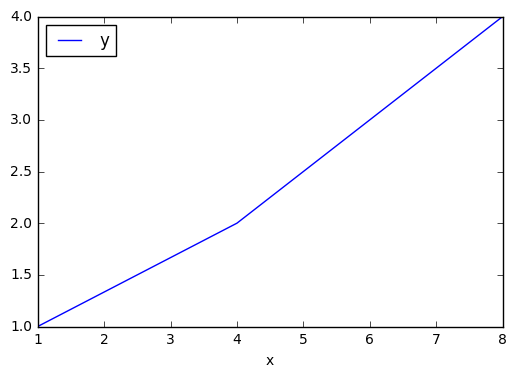

In [3]:
# Plot data
df.plot(kind = 'line', x = 'x', y = 'y')

In Linear Regression, we're trying to essentially fit

$$y=mx+b$$

where we are trying to find $m$ and $b$.

In a multi-dimensional setting, we are trying to figure out $m_n$ in

$$y=m_1x_1+m_2x_2+...+m_nx_n+b$$

Our calculation becomes a linear algebra problem. This linear regression problem doesn't _**seem**_ (mitigating my lack of expertise here) to be able to be distributed _**mathematically**_, but what we _**can**_ do is to take a _**stochastic**_ approach.

If we had 1B rows of data to peform linear regression on, we'd end up splitting the data up into, let's say, 100 distributions of 10M rows of data. Each of these would perform linear regression on its own set of data, then the _**reduce**_ step would be to essentially average out and estimate the true value of $m$ and $b$.

I'm not saying that this is the way Spark does it or the most efficient way to do this, but I'm merely trying to illustrate the point of a _**distributed ML algorithm**_.

In our example, maybe our cluster has 2 workers and each worker takes 2 of our sample points.

In [11]:
# Take first two samples as sample #1
df1 = df.head(2)

# View dataframe
df1

,x,y
0,1,1
1,4,2


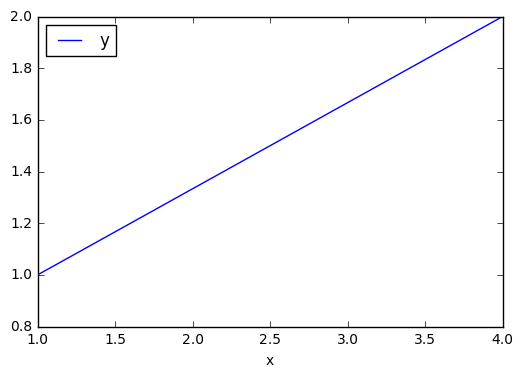

In [9]:
# Plot data of sample #1
df1.plot(kind = 'line', x = 'x', y = 'y')

Here, we can easily calculate our $m$ and $b$ by hand:

$$m=\frac{y_2-y_1}{x_2-x_1}=\frac{2-1}{4-1}=\frac{1}{3}$$

$$b=y_1-mx_1=1-(\frac{1}{3})(1)=\frac{2}{3}$$

In [8]:
# Take last two samples as sample #2
df2 = df.tail(2)

# View dataframe
df2

,x,y
2,6,3
3,8,4


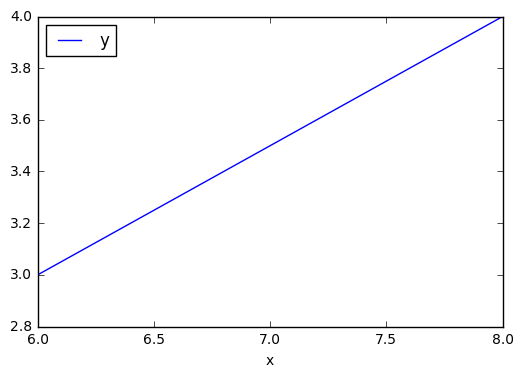

In [12]:
# Plot data of sample #2
df2.plot(kind = 'line', x = 'x', y = 'y')

Similarly,

$$m=\frac{y_2-y_1}{x_2-x_1}=\frac{4-3}{8-6}=\frac{1}{2}$$

$$b=y_1-mx_1=3-(\frac{1}{2})(6)=0$$

If we average these two together, we get

$$m=\frac{5}{12}$$
$$b=\frac{1}{3}$$

Let's use sklearn to find the true $m$ and $b$:

In [20]:
from sklearn import linear_model

# Initiate linear regression model object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(df['x'].reshape(-1, 1), df['y'].reshape(-1, 1))

# Print coefficients
print('Coefficients: {}, Intercept: {}'.format(regr.coef_, regr.intercept_))

Coefficients: [[ 0.42990654]], Intercept: [ 0.45794393]


$m$ is off by $\approx3\%$, but $b$ is off from its true value by $\approx37\%$! An absolutely unacceptable value. However, the fact that we only have 2 rows of data within each sample should be taken into account. By the central limit theorem (CLT):

$$Standard\ Error=\frac{\sigma}{\sqrt{n}}$$

Note that the error depends directly on the number of samples, $n$, so here, our standard error should be quite high. Here is where large data sets come into play - the more samples we have, obviously the more confident we are of our prediction and the smaller our standard error becomes!

Distributed computing - another process that depends heavily on the CLT!

That's probably good for Spark for now. Let's finally open up a notebook and play around with the data!